In [1]:
# utility
import sys
sys.path.append("..")

import utility

# data processing
import numpy as np

# modelling
from sklearn.neighbors import LocalOutlierFactor

# Tree Visualization
import matplotlib.pyplot as plt

In [2]:
start_time = utility.time.time()

stop_thread = False

# global parameters
max_cpu_usage = 0
max_memory_usage = 0

def collect_cpu_mem_usage():
    global max_cpu_usage, max_memory_usage

    while not stop_thread:
        # Get current CPU and memory usage
        cpu_usage = utility.psutil.cpu_percent()
        memory_usage = utility.psutil.virtual_memory().percent

        # Initialize variables if not yet assigned
        if max_cpu_usage is None:
            max_cpu_usage = cpu_usage
        if max_memory_usage is None:
            max_memory_usage = memory_usage

        # Update maximum values if needed
        max_cpu_usage = max(max_cpu_usage, cpu_usage)
        max_memory_usage = max(max_memory_usage, memory_usage)

        # Sleep for a short interval (adjust as needed)
        utility.time.sleep(1)

# Start the function in a separate thread
thread = utility.threading.Thread(target=collect_cpu_mem_usage)
thread.start()

In [3]:
train_data, test_data, train_labels, test_labels, test_true_labels, anom_data = utility.preprocess_data(False, n_anomalies=12000, n_samples=-1)

345
Splitting data
normalize data
Reshape data
Convert data
Add anomalies


In [4]:
# data shape
print(train_data.shape)
print(test_data.shape)

# labels shape
print(train_labels.shape)
print(test_labels.shape)
print(test_true_labels.shape)

(37819699, 784)
(12618567, 784)
(37819699,)
(12618567,)
(12618567,)


Dataset split: 37819699 train rows
Dataset split: 37819699 test rows


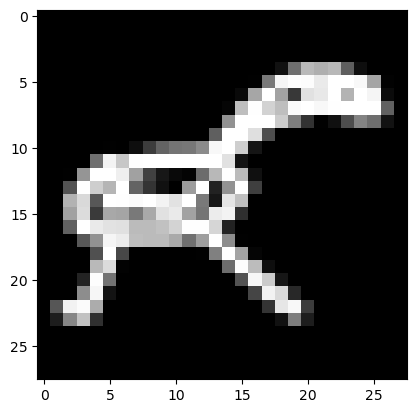

In [5]:
print(f"Dataset split: {len(train_data)} train rows")
print(f"Dataset split: {len(train_labels)} test rows")

point = train_data[0].reshape(28, 28)

plt.imshow(point, cmap='gray')
plt.show()

In [6]:
# parameters
contamination = 0.1
algorithm = 'auto'
leaf_size = 10
metric = 'euclidean'
n_neighbors = 5

In [7]:
# Train the LOF model using data generator
model = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, algorithm=algorithm, leaf_size=leaf_size, novelty=True)

for batch in utility.data_generator(train_data, batch_size=2048):
    # Train the LOF model
    model.fit(batch)

In [8]:
# Get anomaly scores for training and test data
scores_train = utility.scores_generator(model, train_data, batch_size=2048)
scores_test = utility.scores_generator(model, test_data, batch_size=2048)

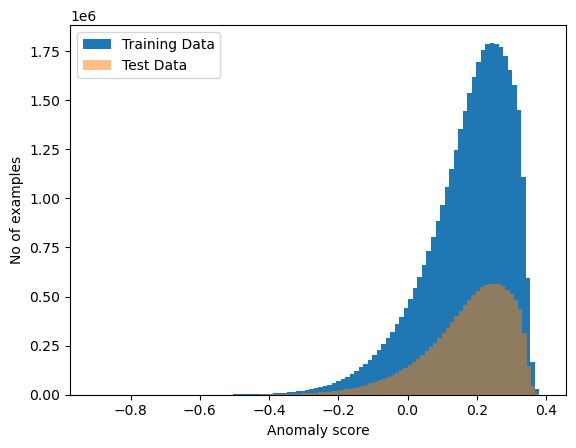

In [9]:
# Plot histograms of anomaly scores for training and test data
plt.hist(scores_train, bins=100, label='Training Data')
plt.hist(scores_test, bins=100, alpha=0.5, label='Test Data')
plt.xlabel("Anomaly score")
plt.ylabel("No of examples")
plt.legend()
plt.show()

In [10]:
# predict
preds = []
for batch in utility.data_generator(test_data):
    # Predict anomalies
    batch_pred = model.predict(batch)
    preds.extend(batch_pred)

# Convert to boolean values
preds = [pred == 1 for pred in preds]

# Convert to numpy array
preds = np.array(preds)

In [11]:
# anomaly scores
anomaly_scores = utility.scores_generator(model, test_data, batch_size=2048)

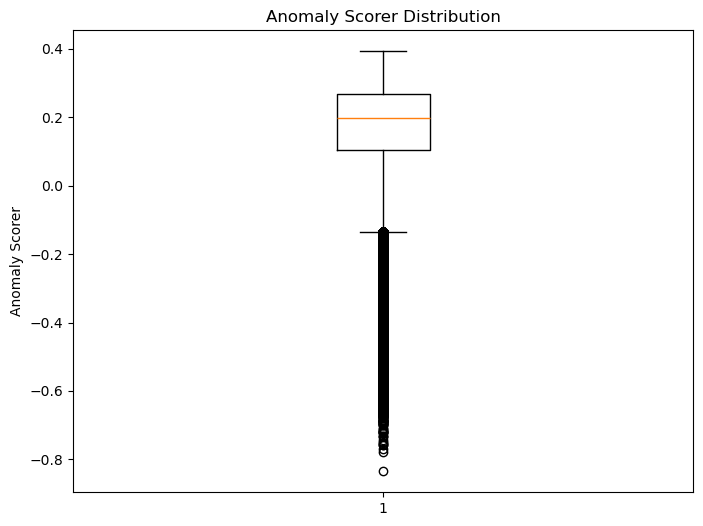

In [12]:
q1, q3, iqr, minimum, maximum = utility.boxplot_plot("Anomaly Scorer", anomaly_scores)

In [13]:
utility.print_boxplot(q1, q3, iqr, minimum, maximum)

Q1:  0.106
Q3:  0.267
IQR:  0.162
Minimum:  -0.137
Maximum:  0.393


/tmp/ipykernel_1492254/3860133023.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(range(len(anomaly_scores)), anomaly_scores, c=['blue' if e > threshold else 'red' for e in anomaly_scores], cmap='coolwarm', marker='o', edgecolors='k')


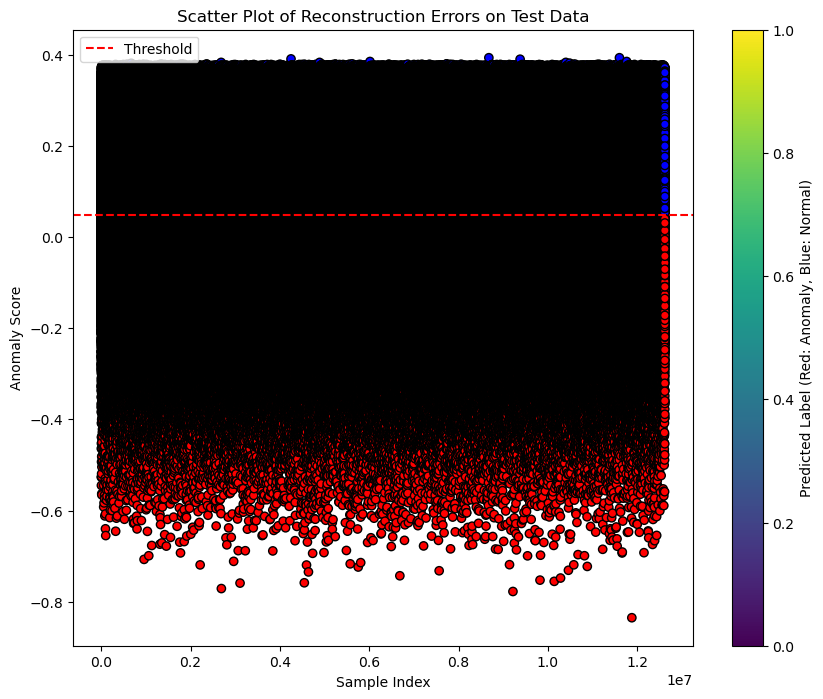

In [14]:
# Set a threshold for classifying anomalies
threshold = np.mean(anomaly_scores) - np.std(anomaly_scores)

# Create a binary array indicating anomalies
anomaly_indicator = np.where(anomaly_scores > threshold, 1, 0)

# Scatter plot with anomalies and normal instances based on anomaly prediction and threshold
plt.figure(figsize=(10, 8))
scatter = plt.scatter(range(len(anomaly_scores)), anomaly_scores, c=['blue' if e > threshold else 'red' for e in anomaly_scores], cmap='coolwarm', marker='o', edgecolors='k')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title('Scatter Plot of Reconstruction Errors on Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.colorbar(scatter, label='Predicted Label (Red: Anomaly, Blue: Normal)')
plt.show()

In [15]:
# Predict anomalies based on the custom threshold
preds = (anomaly_scores > threshold).astype(int)

# Convert labels from -1/1 to True/False
preds = preds == 1

In [16]:
a, p, r, f1, report, cm = utility.get_metrics(preds, test_true_labels)

In [17]:
utility.print_stats(a, p, r, f1, report, cm)

Accuracy = 0.8460609671446845
Precision = 0.9990124640846046
Recall = 0.8467514589816562
F1 = 0.9166017939057215
Report
               precision    recall  f1-score   support

     anomaly       0.00      0.12      0.00     12000
      normal       1.00      0.85      0.92  12606567

    accuracy                           0.85  12618567
   macro avg       0.50      0.48      0.46  12618567
weighted avg       1.00      0.85      0.92  12618567

Confusion Matrix
[[    1448    10552]
 [ 1931938 10674629]]


True Negatives: 1448
False Positives: 10552
False Negatives: 1931938
True Positives: 10674629


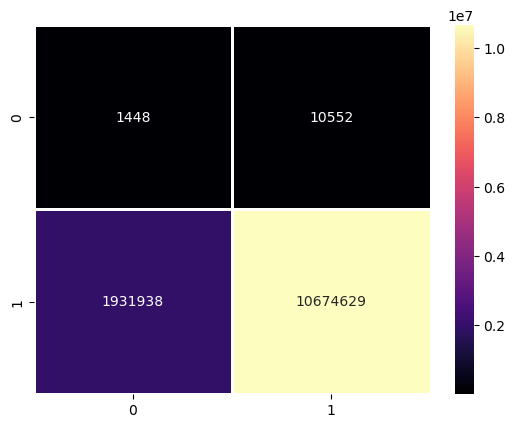

In [18]:
utility.create_heatmap(cm)

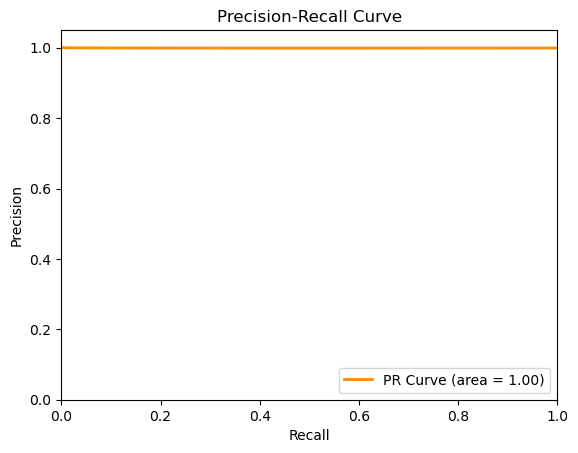

In [19]:
utility.pr_auc_plot(anomaly_scores, test_true_labels, True)

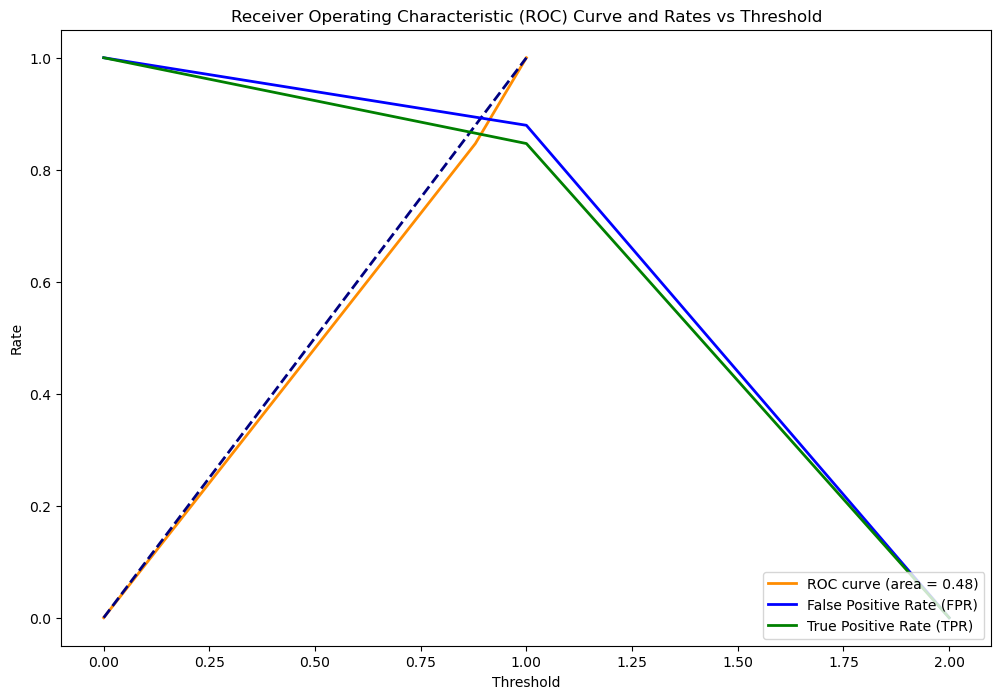

In [20]:
utility.roc_plot(preds, test_true_labels)

In [21]:
# Get anomaly scores for training and test data
scores_train = utility.scores_generator(model, train_data, batch_size=2048)
scores_test = utility.scores_generator(model, test_data, batch_size=2048)
scores_anom = utility.scores_generator(model, anom_data, batch_size=2048)

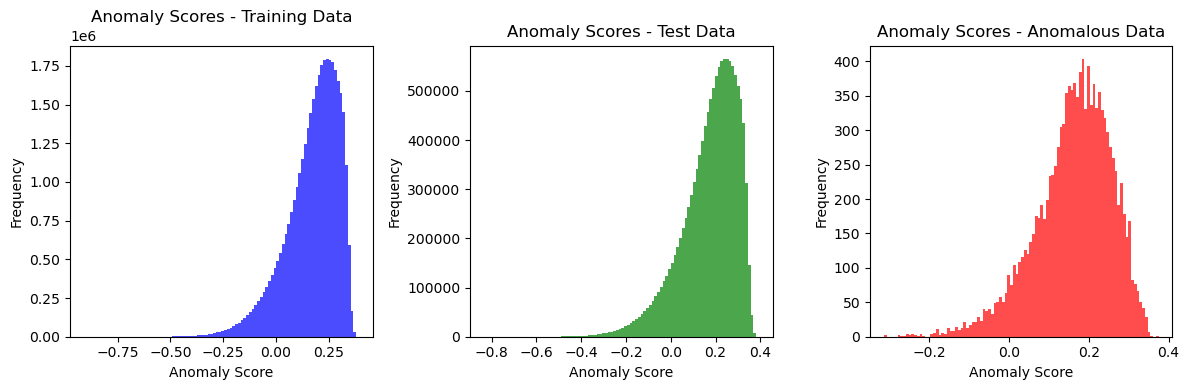

In [22]:
# Plotting histograms
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(scores_train, bins=100, color='blue', alpha=0.7)
plt.title('Anomaly Scores - Training Data')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(scores_test, bins=100, color='green', alpha=0.7)
plt.title('Anomaly Scores - Test Data')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(scores_anom, bins=100, color='red', alpha=0.7)
plt.title('Anomaly Scores - Anomalous Data')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [23]:
anomaly_indexes = utility.write_to_json(preds)

Anomaly indexes saved to ./anomalies.json


1933386


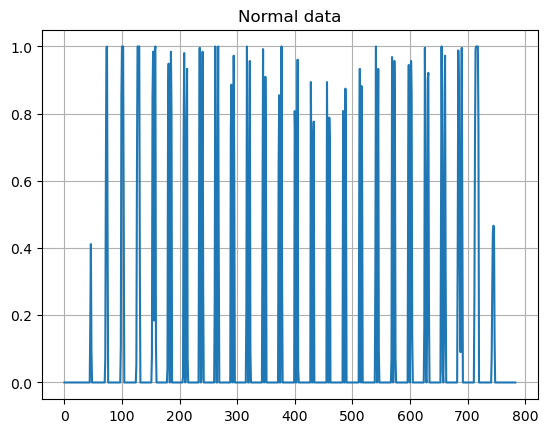

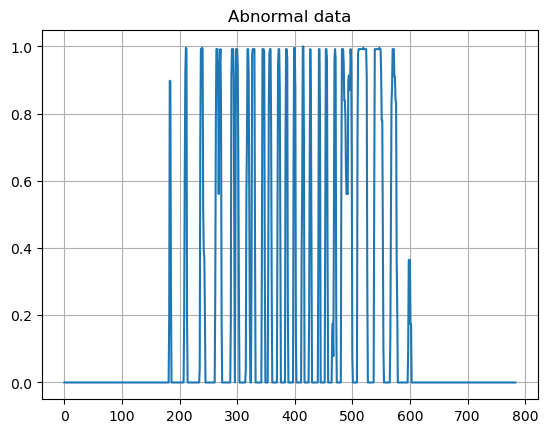

In [24]:
print(len(anomaly_indexes))

utility.plot_normalized_pixel_data(train_data, anom_data)

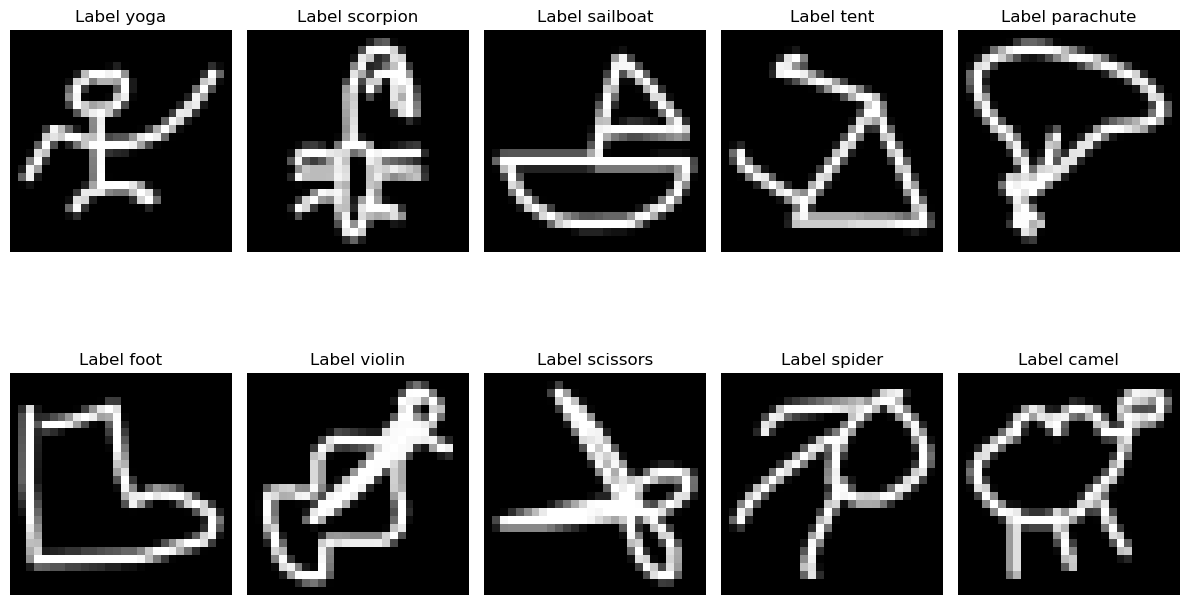

In [25]:
utility.plot_anomaly_imgs(anomaly_indexes, test_data, test_labels)

In [26]:
stop_thread = True

thread.join()
print(f"CPU Usage: {max_cpu_usage}%")
print(f"Memory Usage: {max_memory_usage}%")

CPU Usage: 88.0%
Memory Usage: 78.6%


In [27]:
end_time = utility.time.time()
total_time = end_time - start_time
print(f"Total execution time: {total_time} seconds")

Total execution time: 11249.081258296967 seconds
